AML - VOC 2012

Volpato Mattia 866316

## Imports and utility

In [1]:
!pip install pympler #use ! on colab, use % on local machine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 6.3 MB/s eta 0:00:00


In [2]:
colab=True

In [3]:
if colab:
    from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pympler import asizeof

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [4]:
RANDOM_STATE = 17
N_IMAGES_TO_SHOW = 10
N_CLASSES = 20
IMG_SIZE = (64, 64)#da 128x128

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
keras.utils.set_random_seed(RANDOM_STATE)

In [5]:
if colab:
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
if colab:
    ROOT_DIR = '/content/drive/MyDrive/'
    BASE_DIR = ROOT_DIR + 'project/dataset/compressed/'
else:
    BASE_DIR = '../dataset/compressed/'
BASE_DIR

'/content/drive/MyDrive/project/dataset/compressed/'

In [7]:
TRAIN_PATH = BASE_DIR + 'train.npz'
VALIDATION_PATH = BASE_DIR + 'validation.npz'
TEST_PATH = BASE_DIR + 'test.npz'

TRAIN_PATH, VALIDATION_PATH, TEST_PATH

('/content/drive/MyDrive/project/dataset/compressed/train.npz',
 '/content/drive/MyDrive/project/dataset/compressed/validation.npz',
 '/content/drive/MyDrive/project/dataset/compressed/test.npz')

In [8]:
def plot_history(history) -> None:
    metrics = list(history.history.keys())

    n_metrics = len([m for m in metrics if not m.startswith('val_')])
    n_cols = 2
    n_rows = (n_metrics + 1) // 2  # Arrotonda per eccesso

    fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.tight_layout(pad=3.0)

    if n_rows > 1:
        axis = axis.flatten()

    plot_index = 0

    base_metrics = [m for m in metrics if not m.startswith('val_')]

    for metric in base_metrics:
        val_metric = f'val_{metric}'

        if metric not in history.history:
            continue

        train_data = history.history[metric]
        val_data = history.history[val_metric] if val_metric in history.history else None

        if n_rows > 1:
            current_axis = axis[plot_index]
        else:
            current_axis = axis[plot_index] if n_cols > 1 else axis

        current_axis.set_title(f'{metric.capitalize()}')
        current_axis.set_xlabel('Epochs')
        current_axis.set_ylabel(metric.capitalize())

        current_axis.plot(train_data, label=f'Training {metric.capitalize()}')
        if val_data is not None:
            current_axis.plot(val_data, label=f'Validation {metric.capitalize()}')

        current_axis.legend()

        plot_index += 1

    while plot_index < len(axis):
        fig.delaxes(axis[plot_index])
        plot_index += 1

    plt.show()

In [9]:
CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

classes_map = {c: i for i, c in enumerate(CLASSES)}
classes_map

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

In [10]:
def vector_encoding(labels:list[int], num_classes:int):
    class_vector = np.zeros(num_classes)
    for label in labels:
      class_vector[classes_map[label]] = 1
    return class_vector

# Convert labels to one-hot encoding
def one_hot_encode(labels, num_classes):
    one_hot_labels = np.zeros((labels.size, num_classes))
    one_hot_labels[np.arange(labels.size), labels] = 1
    return one_hot_labels

In [11]:
def preprocess_images(images: np.ndarray, resize=IMG_SIZE):
    images /= 255.0
    resized_images = []

    for i in range(images.shape[0]):
        resized_image = tf.image.resize(images[i], resize).numpy()
        resized_images.append(resized_image)

    resized_images = np.array(resized_images)
    del images

    return resized_images

## loading trained ssl model (rotation classification task)

In [13]:
model = tf.keras.models.load_model('baseline_ssl_modela.keras')

# Check its architecture
model.summary()


Model: "baseline_ssl_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout (Dropout)                    │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 60, 60, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 60, 60, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 696,270 (2.66 MB)

 Trainable params: 231,876 (905.77 KB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 463,754 (1.77 MB)

# Loading raw photos and finetuning on augmented trainset

## Training set

In [14]:
train_data = np.load(TRAIN_PATH, allow_pickle=True)
train_data

NpzFile '/content/drive/MyDrive/project/dataset/compressed/train.npz' with keys: images, labels

In [15]:
train_images = train_data['images']
train_images.shape

(9232, 227, 227, 3)

In [16]:
print(f'Size of train images before preprocessing: {asizeof.asizeof(train_images) / (1024**3)} GB')

Size of train images before preprocessing: 5.316537722945213 GB


Image preprocessing:

In [17]:
train_images = preprocess_images(train_images)
train_images.shape

(9232, 64, 64, 3)

In [18]:
print(f'Size of train images after preprocessing: {asizeof.asizeof(train_images) / (1024**3)} GB')

Size of train images after preprocessing: 0.42260758578777313 GB


Labels encoding:

In [19]:
train_labels = train_data['labels']
train_labels.shape

(9232,)

In [20]:
print(f'Size of train labels before encoding: {asizeof.asizeof(train_labels) / (1024**2)} MB')

Size of train labels before encoding: 0.0706024169921875 MB


In [21]:
encoded_train_labels = np.array([vector_encoding(l, N_CLASSES) for l in train_labels])
encoded_train_labels.shape, encoded_train_labels[0], train_labels[0]

((9232, 20),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1.]),
 ['tvmonitor'])

In [22]:
print(f'Size of train labels after encoding: {asizeof.asizeof(train_labels) / (1024**2)} MB')

Size of train labels after encoding: 0.0706024169921875 MB


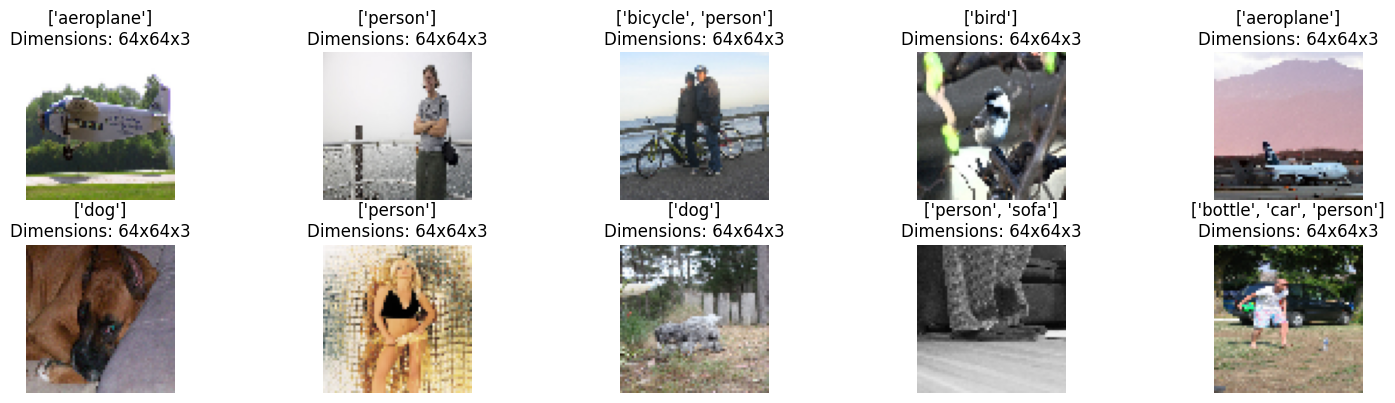

In [23]:
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(train_images.shape[0], size=N_IMAGES_TO_SHOW, replace=False)
labels = [l for l in train_labels[random_indices]]
images = [i for i in train_images[random_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

### creating the augm. pipeline

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=25,           # Rotazione casuale fino a ±25 gradi
    width_shift_range=0.2,       # Traslazione orizzontale fino al 20% della larghezza
    height_shift_range=0.2,      # Traslazione verticale fino al 20% dell'altezza
    shear_range=0.25,            # Trasformazione prospettica (shear) fino al 25%
    zoom_range=[0.8, 1.2],       # Zoom casuale tra il 70% e il 130%
    channel_shift_range = 0.3,   # Variazione di intensità dei colori fino al 30%
    preprocessing_function=lambda x: np.fliplr(x) if np.random.random() < 0.3 else x,   # Flip orizzontale con probabilità del 30%
    fill_mode='nearest'          # Riempimento dei pixel mancanti
)

train_datagen.fit(train_images)

BATCH_SIZE = 64

# Crea un generatore per i dati di training
train_generator = train_datagen.flow(
    train_images,
    encoded_train_labels,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
train_generator

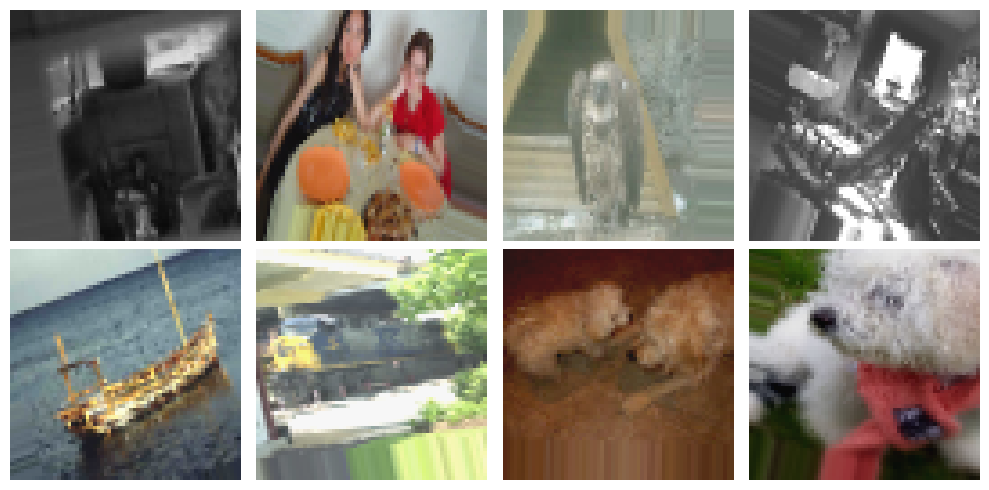

In [25]:
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    for x, y in train_generator:
        plt.imshow(x[0])
        plt.axis('off')
        break

plt.tight_layout()
plt.show()

## Validation set

In [26]:
validation_data = np.load(VALIDATION_PATH, allow_pickle=True)
validation_data

NpzFile '/content/drive/MyDrive/project/dataset/compressed/validation.npz' with keys: images, labels

In [27]:
validation_images = validation_data['images']
validation_images.shape

(1154, 227, 227, 3)

In [28]:
print(f'Size of validation images before preprocessing: {asizeof.asizeof(validation_images) / (1024**3)} GB')

Size of validation images before preprocessing: 0.6645673587918282 GB


Image preprocessing:

In [29]:
validation_images = preprocess_images(validation_images)
validation_images.shape

(1154, 64, 64, 3)

In [30]:
print(f'Size of validation images after preprocessing: {asizeof.asizeof(validation_images) / (1024**3)} GB')

Size of validation images after preprocessing: 0.05282609164714813 GB


Labels encoding:

In [31]:
validation_labels = validation_data['labels']
validation_labels.shape

(1154,)

In [32]:
encoded_validation_labels = np.array([vector_encoding(l, N_CLASSES) for l in validation_labels])
encoded_validation_labels.shape, encoded_validation_labels[0], validation_labels[0]

((1154, 20),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 ['boat'])

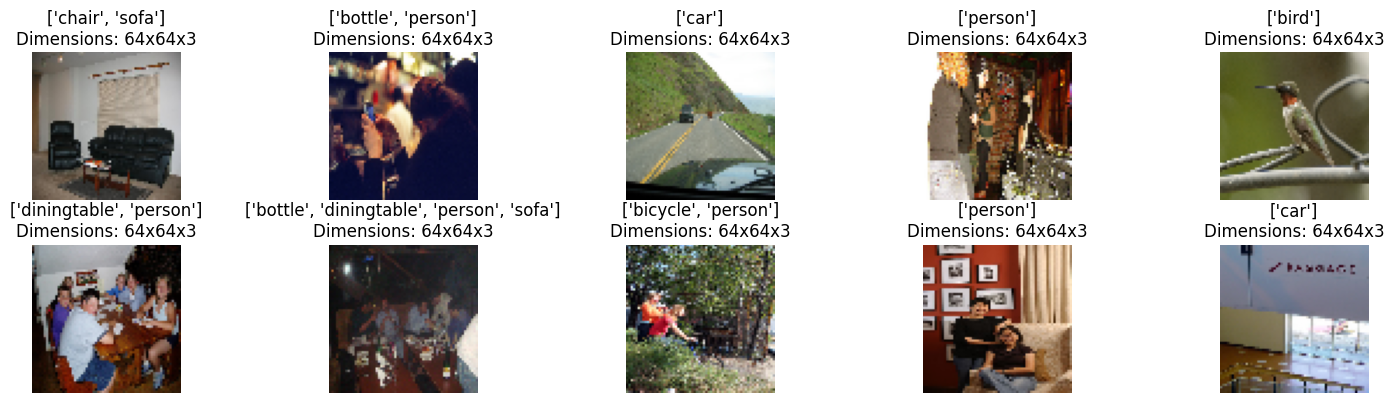

In [33]:
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(validation_images.shape[0], size=N_IMAGES_TO_SHOW, replace=False)
labels = [l for l in validation_labels[random_indices]]
images = [i for i in validation_images[random_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

## supervised finetuning on augmented

In [55]:
#from tensorflow.keras.models import load_model
#model = load_model(f"{model.name}.keras")

for layer in model.layers:
    layer.trainable=False

model.pop()
model.add(layers.Dense(20, activation='sigmoid', name='newDenseForVocClasses') )

model.layers[-1].trainable=True
model.layers[-2].trainable=True
model.layers[-3].trainable=True
model.layers[-4].trainable=True

#model.layers[-1] = layers.Dense(20, activation='sigmoid')

from tensorflow.keras.metrics import AUC
# Mean Average Precision (mAP) usando AUC con curva Precision-Recall
map_metric = AUC(
    curve='PR',  # Precision-Recall curve
    multi_label=True,
    name='mAP'
)

# Top-3 Accuracy
top_3_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(
    k=3,
    name='top_3_accuracy'
)


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        top_3_accuracy,
        map_metric
    ]
)


# Fix possible problems with new model
model.save('temp.keras')
model = tf.keras.models.load_model('temp.keras')


In [59]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
early_stopping

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='baseline_augmented_model_epoch_{epoch:02d}.keras',
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    save_best_only=True
    )

In [57]:
encoded_validation_labels.shape

(1154, 20)

In [60]:
history = model.fit(
    train_generator,
    validation_data=(validation_images, encoded_validation_labels),
    epochs=500,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 0.0876 - loss: 0.7426 - mAP: 0.0771 - top_3_accuracy: 0.1928 - val_accuracy: 0.0927 - val_loss: 0.3624 - val_mAP: 0.0838 - val_top_3_accuracy: 0.2470
Epoch 2/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.0880 - loss: 0.4341 - mAP: 0.0751 - top_3_accuracy: 0.2235 - val_accuracy: 0.1300 - val_loss: 0.2501 - val_mAP: 0.0897 - val_top_3_accuracy: 0.3224
Epoch 3/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.1338 - loss: 0.3355 - mAP: 0.0781 - top_3_accuracy: 0.2922 - val_accuracy: 0.1369 - val_loss: 0.2433 - val_mAP: 0.0956 - val_top_3_accuracy: 0.3778
Epoch 4/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.1352 - loss: 0.3135 - mAP: 0.0781 - top_3_accuracy: 0.3105 - val_accuracy: 0.1360 - val_loss: 0.2406 - val_mAP: 0.1005 - val_top_3_accuracy: 0.3813
Epoch 5/500
145/145 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.1356 - loss: 0.3011 - mAP: 0.0799 - top_3_accuracy: 0.3142 - v

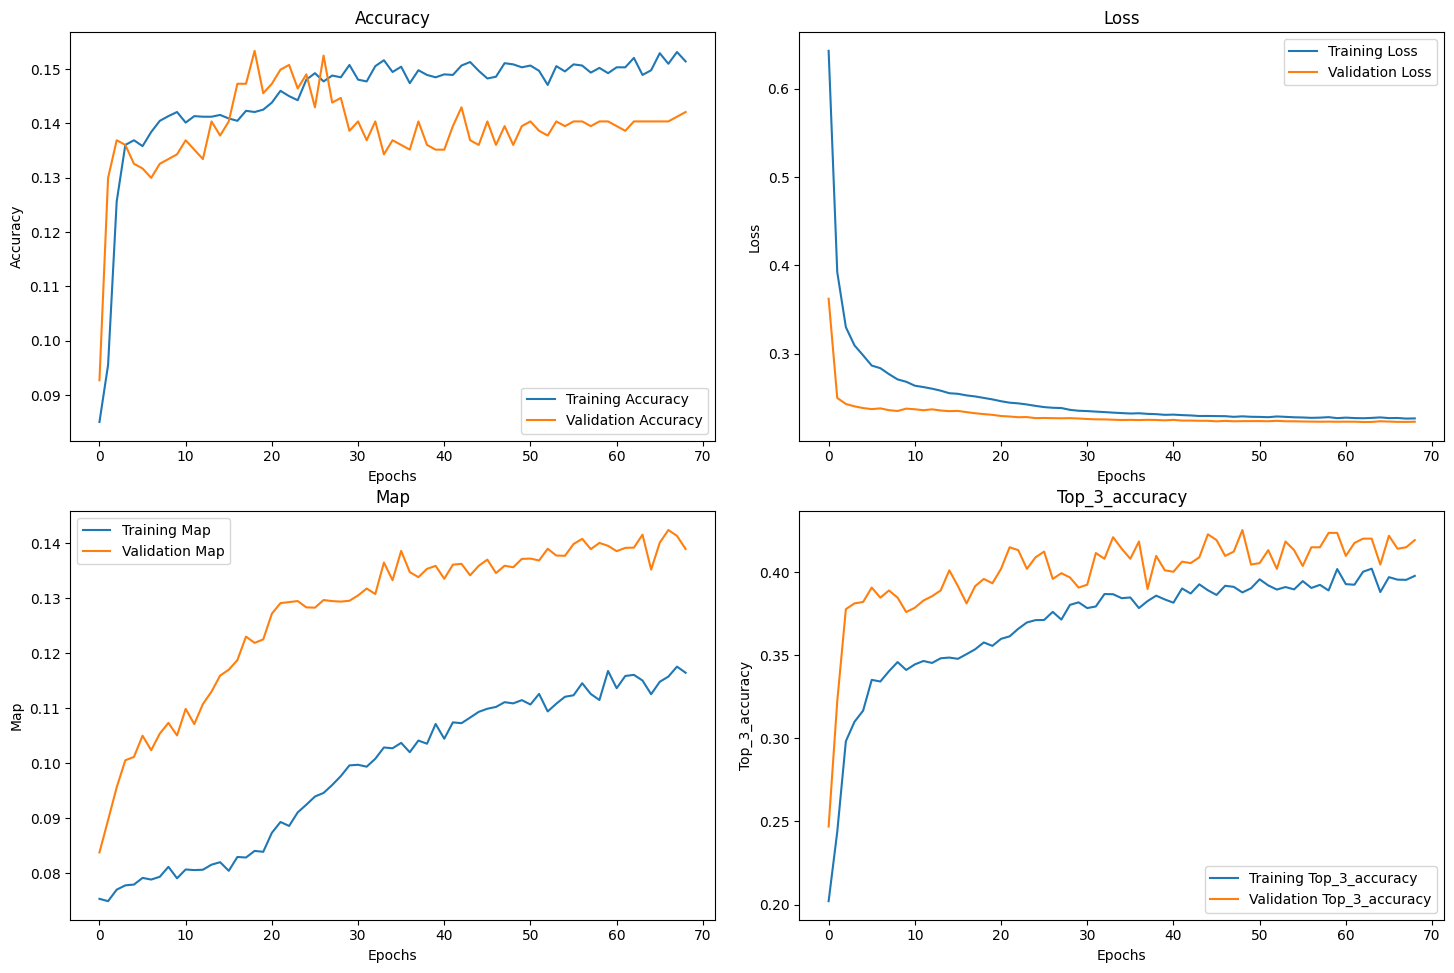

In [76]:
plot_history(history)

In [77]:
model.save(f"{model.name}_finetuned_on_aug.keras")

# Test

### loading Test set

In [78]:
test_data = np.load(TEST_PATH, allow_pickle=True)
test_data

NpzFile '/content/drive/MyDrive/project/dataset/compressed/test.npz' with keys: images, labels

In [79]:
test_images = test_data['images']
test_images.shape

(1154, 227, 227, 3)

In [80]:
print(f'Size of test images before preprocessing: {asizeof.asizeof(test_images) / (1024**3)} GB')

Size of test images before preprocessing: 0.6645673587918282 GB


Image preprocessing:

In [81]:
test_images = preprocess_images(test_images)
test_images.shape

(1154, 64, 64, 3)

In [82]:
print(f'Size of test images after preprocessing: {asizeof.asizeof(test_images) / (1024**3)} GB')

Size of test images after preprocessing: 0.05282609164714813 GB


Labels encoding:

In [83]:
test_labels = test_data['labels']
test_labels.shape

(1154,)

In [84]:
encoded_test_labels = np.array([vector_encoding(l, N_CLASSES) for l in test_labels])
encoded_test_labels.shape, encoded_test_labels[0], test_labels[0]

((1154, 20),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1.]),
 ['bottle', 'person', 'tvmonitor'])

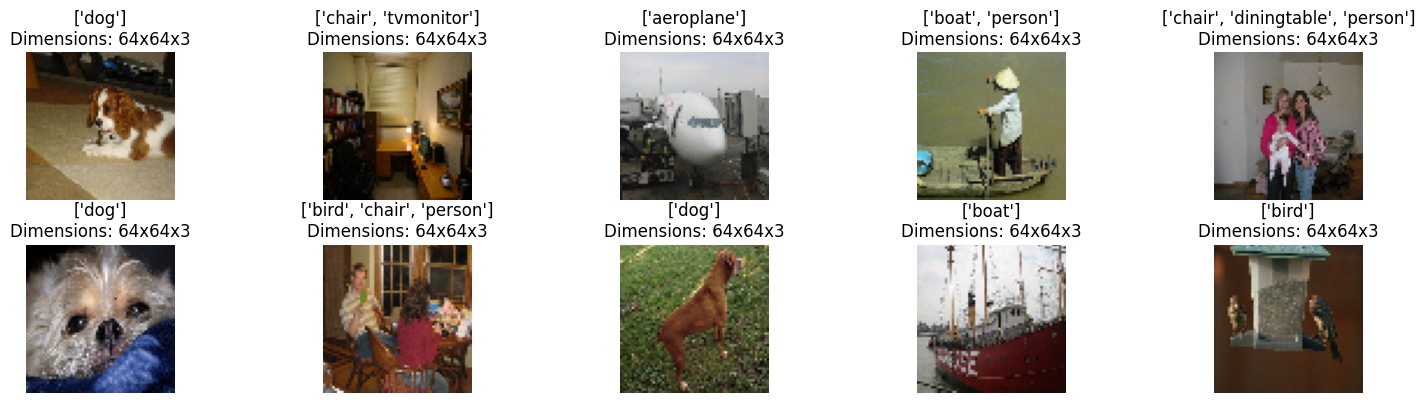

In [85]:
np.random.seed(RANDOM_STATE)
random_indices = np.random.choice(test_images.shape[0], size=N_IMAGES_TO_SHOW, replace=False)
labels = [l for l in test_labels[random_indices]]
images = [i for i in test_images[random_indices]]

fig, axes = plt.subplots(2, len(images) // 2, figsize=(15, 4))
fig.tight_layout()

for i, axis in enumerate(axes.flat):
    axis.imshow(images[i])
    axis.axis('off')
    image_size = images[i].shape
    axis.set_title(f'{labels[i]}\nDimensions: {image_size[0]}x{image_size[1]}x{image_size[2]}')

plt.show()

## predict on testset

In [86]:
y_pred = model.predict(test_images)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [87]:
accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
accuracy.update_state(encoded_test_labels, y_pred)

accuracy.result().numpy()

0.14384748

In [88]:
top_3_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=3)
top_3_accuracy.update_state(encoded_test_labels, y_pred)

top_3_accuracy.result().numpy()

0.39428076

In [89]:
map_metric = tf.keras.metrics.AUC(
    curve='PR',
    multi_label=True
)

map_metric.update_state(encoded_test_labels, y_pred)
map_metric.result().numpy()

0.113627315

In [90]:
metrics = {
    'Accuracy': accuracy.result().numpy(),
    'Top-3 Accuracy': top_3_accuracy.result().numpy(),
    'mAP': map_metric.result().numpy()
}

metrics

{'Accuracy': 0.14384748, 'Top-3 Accuracy': 0.39428076, 'mAP': 0.113627315}